In [2]:
cd ..

/Users/AchilleTalon/Documents/GitHub/ice-accummulation-M17


## Aim

The aim of this notebook is to display the results of an age depth model run with the M-17 data, as sampled and highlight the posterior probability of each sample being an outlier in the stratigraphy. We use an outlier model in OxCal.

## Loading useful modules and local scripts

In [15]:
import numpy as np 
import seaborn as sns
import subprocess
import json
import matplotlib.pyplot as plt

from IPython.display import Markdown as md   # for nice displaying of tables...
from sklearn.preprocessing import normalize

import scripts.OxcalReader as ox


The input OxCal code can be found [here](http://localhost:8888/edit/ice-accummulation-M17/data/age_model/M17_stratigraphy_outlier.oxcal)


For completeness, we also display the full code below.

In [39]:
with open('data/age_model/M17_stratigraphy_outlier.oxcal', 'r') as f:
    d = f.readlines()
    f.close()
    
code = '```'
for line in d:
    code+= line
code +='```'

In [40]:
md(code)

``` Plot()
 {
  Outlier_Model("General",T(5),U(0,4),"t");
  P_Sequence("M17_ice_shaft",1,.5,U(-2,2))
  {
   Boundary(Start)
   {
    z=700;
   };
   R_Date("MIG-7",905,31)
   {
    z=680;
    Outlier(0.05);
   };
   R_Date("MIG-8",951,26)
   {
    z=655;
    Outlier(0.05);
   };
   R_Date("MIG-9",1044,26)
   {
    z=630;
    Outlier(0.05);
   };
   R_Date("MIG-10",695,24)
   {
    z=585;
    Outlier(0.05);
   };
   R_Date("MIG-1",1060,22)
   {
    z=585;
    Outlier(0.05);
   };
   R_Date("MIG-2",1119,36)
   {
    z=510;
    Outlier(0.05);
   };
   R_Date("MIG-4",912,32)
   {
    z=370;
    Outlier(0.05);
   };
   R_Date("MIG-3",682,30)
   {
    z=370;
    Outlier(0.05);
   };
   R_Date("MIG-C1",762,35)
   {
    z=230;
    Outlier(0.05);
   };
   R_Date("MIG-C2",1172,23)
   {
    z=220;
    Outlier(0.05);
   };
   R_Date("MIG-C4",1068,34)
   {
    z=110;
    Outlier(0.05);
   };
   R_Date("MIG-C6",759,23)
   {
    z = 0;
    Outlier(0.05);
   };
   R_Date("MIG-5",595,23)
   {
    z = 0;
    Outlier(0.05);
   };
   Boundary(End)
   {
    z= 0;
   };
  };
 };
```

## Reading the OxCal output file

In [6]:
# we call the LoadFile function from the OxcalReader script
M17 = ox.LoadFile('data/age_model/M17_stratigraphy_outlier.js')

### Obtaining the complete depth model from the M17 object

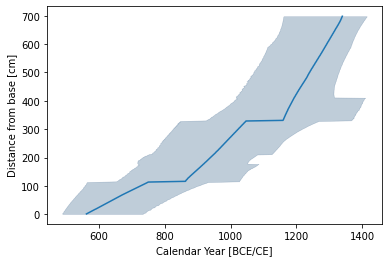

In [7]:
# we create a median and 95.4% interval depth model - this becomes a 2D array
# we preemptively convert z (depth) to distance from the base by subtracting z [cm] from 700.
depth_mod =  np.transpose(np.array([(700-k['data']['z'],
                                     k['posterior']['median'],
                                     k['posterior']['range'][-2][0][0],
                                     k['posterior']['range'][-2][0][1])
                                    for k in M17['ocd'][22:]]))

# quick plot of the depth model
fig, ax = plt.subplots()
ax.plot(depth_mod[1],depth_mod[0])
ax.fill_betweenx(x1=depth_mod[2],x2 = depth_mod[3],y=depth_mod[0],color = 'xkcd:marine blue',lw=0.5, alpha = 0.25)
ax.set_xlabel('Calendar Year [BCE/CE]')
ax.set_ylabel('Distance from base [cm]')
plt.show()

### Obtaining the PDFs for each radiocarbon date from the M17 object

We cycle through the nested `M17['ocd']` dictionary and assign a colour value for the plot depending on the agreement index. We also create normalised PDF arrays from the dictionary for easier plotting later on.

In [8]:
dates = []
for c,d in enumerate(M17['ocd']):
    palette = sns.diverging_palette(140, 25, as_cmap = True)
    
    try:
        if d['name'].startswith('MIG'):

            temp = {}
            
            temp['z'] = 700-d['data']['z']
            agg = float(d['posterior']['comment'][-1][-5:-1])
            temp['text'] = '{} (A: {}%)'.format(d['name'], agg)
            temp['color'] = palette(np.linspace(1,0,100))[np.argmin(np.abs(np.linspace(0,1,100)-.01*agg))]

            # return likelihood and posterior:
            for j in ('likelihood','posterior'):
                p =  d[j]['prob']
                r = d[j]['resolution']
                s = d[j]['start']
            
                y = np.array(p)
                y = y / np.sum(y)
                x = np.arange(s,s+r*len(y),r)
                temp[j] = np.array([x,y])
    
            dates.append(temp)  
    except:
        continue

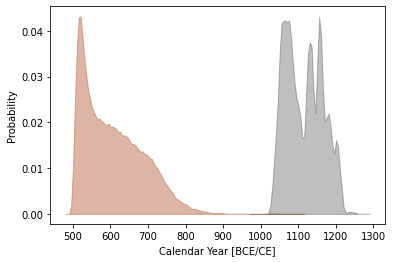

In [9]:
# we can quickly plot the difference between a marginal posterior and the likelihood distribution

fig, ax = plt.subplots()
post = dates[0]['posterior']
like = dates[0]['likelihood']
ax.fill_between(post[0],post[1],color = dates[0]['color'],alpha = 0.5)
ax.fill_between(like[0],like[1],color = 'k', alpha = 0.25)
ax.set_xlabel('Calendar Year [BCE/CE]')
ax.set_ylabel('Probability')
plt.show()

### Creating the figure

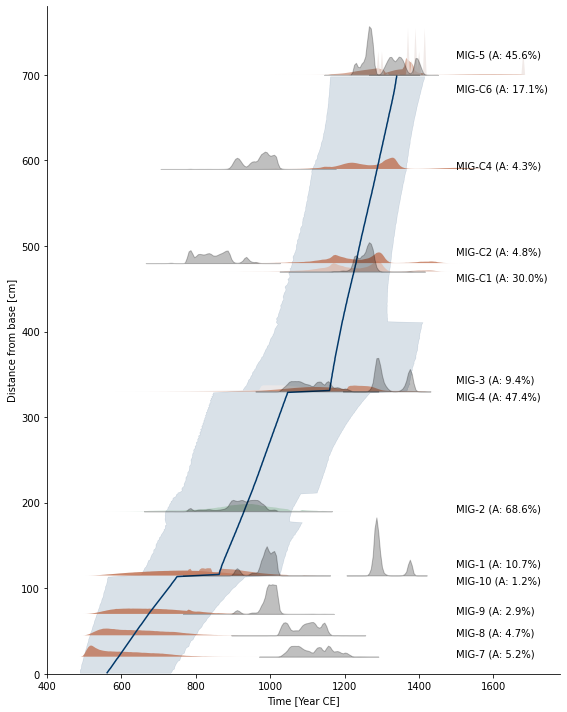

In [10]:
fig, ax = plt.subplots(figsize = (8,10))

plot_offsets = [0,0,0,-0.5,0.5,0,-0.5,0.5,-0.5,0.5,0,-1,1]


ax.plot(depth_mod[1],depth_mod[0],color = 'xkcd:marine blue')
ax.fill_betweenx(x1=depth_mod[2],x2 = depth_mod[3],y=depth_mod[0],color = 'xkcd:marine blue',lw=0.5, alpha = 0.15)





for d,off in zip(dates, plot_offsets):
    ax.text(y = d["z"]+20*off,x = 1500,s = d['text'])
    ax.fill_between(y1 = d['z'],x = d['posterior'][0],
                    y2 = d['z']+300*d['posterior'][1], 
                    color = d['color'], alpha = 0.75, edgecolor = None,zorder = 1)
    ax.fill_between(y1 = d['z'],x = d['likelihood'][0],
                    y2 =d['z']+300*d['likelihood'][1],
                    color = 'k', alpha = 0.25, zorder = 100)

ax.set_ylabel('Distance from base [cm]')
ax.set_xlabel('Time [Year CE]')
ax.set_xlim(400,1780)
ax.set_ylim(0,780)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.tight_layout()
plt.savefig('outputs/sf09.pdf',dpi = 300)

#plt.savefig('../reports/M17_manuscript/sf09.pdf',dpi = 300)
plt.show()
plt.close(fig)